## ECI 249 HW 3

Kennth Larrieu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

### 1. Frat House Optimal Lifetime

Average time between house-burnings:

$$\mathbb{E}[T] = \sum_{t=1}^{\infty} t \cdot P(\text{burns in t-th year}) = \sum_{t=1}^{\infty} t \cdot (1-p)^{t-1}(p) = \frac{p}{1-p} \sum_{t=1}^{\infty} t (1-p)^t = \frac{p}{1-p} \frac{1-p}{(p)^2} = \frac{1}{p}$$

A. fire-proof frat house: $\mathbb{E}[T] = \frac{1}{0} = \infty$

B. fire-resistant frat house: $\mathbb{E}[T] = \frac{1}{0.05} = 20 \text{ yrs}$

C. normal frat house: $\mathbb{E}[T] = \frac{1}{0.1} = 10 \text{ yrs}$

#### a. Deterministic Approach

$$W = C + We^{-rT}$$

$$W = \frac{C}{1-e^{-rT}}$$

$$$$

In [2]:
costs = [1000000, 300000, 150000]
ps = [0, 0.05, 0.1]
Ts = [np.inf, 20, 10]

det_costs = []
for c, p, T in zip(costs, ps, Ts):
    evc = c/(1 - np.e**(-0.05 * T))
    det_costs.append(round(evc, 2))

#### b. Analytical Approach

Expected Value of Cost:

$$W = C + W \sum_{t=1}^{\infty} e^{-rt} (1-p)^{t-1}(p) = C + W \frac{p}{1-p} \sum_{t=1}^{\infty} (e^{-r}(1-p))^t$$

$$W = C + W \frac{p}{1-p} \frac{(e^{-r}(1-p))}{1-(e^{-r}(1-p))}, \quad \rightarrow \quad W = \frac{C}{\left(1 - \frac{p}{e^r - (1-p)}\right)}$$

In [3]:
analytical_costs = []
for c, p, in zip(costs, ps):
    evc = c/(1-p/(np.e**0.05 - (1-p)))
    analytical_costs.append(round(evc, 2))

#### c. Monte Carlo Approach:

In [4]:
class FratHouse:
    def __init__(self, cost, p, runs=10**5):
        # cost of frat house
        self.cost = cost
        # annual probability of fire
        self.p = p
        # number of years for each run
        self.sample_size = 10**3
        # discount rate
        self.r = 0.05
        # number of runs
        self.runs = runs
        self.mean_cost = self.mc_average()
    
    def monte_carlo(self):
        run_cost = self.cost
        samples = np.random.random(self.sample_size)
        for t, sample in enumerate(samples):
            if sample <= self.p:
                run_cost += self.cost*np.e**((-self.r)*(t+1))
        return run_cost
    
    def mc_average(self):
        run_costs = []
        for run in range(self.runs):
            run_cost = self.monte_carlo()
            run_costs.append(run_cost)
        mean_cost = np.mean(run_costs)
        return round(mean_cost, 2)
    
FireProof = FratHouse(1000000, 0)
FireResistant = FratHouse(300000, 0.05)
NormalHouse = FratHouse(150000, 0.1)

In [5]:
mc_costs = [FireProof.mean_cost, FireResistant.mean_cost, NormalHouse.mean_cost]
df = pd.DataFrame([det_costs, analytical_costs, mc_costs], columns=['Fireproof', 'Fire Resistant', 'Normal House'], index=['Deterministic Estimate', 'Analytical Solution', 'Monte Carlo'])
df

,Fireproof,Fire Resistant,Normal House
Deterministic Estimate,1000000.0,474593.01,381224.11
Analytical Solution,1000000.0,592562.50,442562.50
Monte Carlo,1000000.0,593115.93,442413.68


The average costs from the Monte Carlo simulations very closely approximate the analytical solution. From the average cost for each alternative listed above, it is clear that we want our frat houses to have as little fireproofing as possible.

### 2. Filtration Units

#### a. What is the probability distribution for removal after each number of filters?

Analytical approach:

total efficiency:

$$E = 1-(1-E_1)(1-E_2)...(1-E_n)$$

Where each $E_i = \min\left[\text{Lognormal}(0.9, 0.05), 1\right]$

Assuming the resulting distribution is approximately log-normally distributed, we can use the first-order second moment method to estimate the mean and variance.

$$\mu_E \approx 1 - (1-\mu_{E_1})(1-\mu_{E_2})...(1-\mu_{E_n}) = 1 - (1-0.9)^n = 1 - 0.1^{n}$$

$$\sigma_{E}^2 \approx \sum_{i=1}^n \sum_{j=1}^n \frac{\partial g(\bar{\mu})}{\partial e_i} \frac{\partial g(\bar{\mu})}{\partial e_j} \text{Cov}(E_i, E_j) = \sum_{i=1}^n \sum_{j=1}^n (1-0.9)^{2(n-1)} \text{Cov}(E_i, E_j)$$

The covariance matrix is zero except for diagonals since the $E_i$'s are i.i.d. Therefore:

$$\sigma_{E}^2 \approx n \, (0.05)^2 \, (0.1)^{2(n-1)} = \frac{n}{4} (0.1)^{2n}$$

So the standard deviation is

$$\sigma_{E} \approx \frac{\sqrt{n}}{2} 0.1^n$$

Thus the distribution of overall filter efficiency is approximately $\min\left[\text{Lognormal}\left(1 - 0.1^{n}, \frac{\sqrt{n}}{2} 0.1^n\right), 1\right]$

The corresponding pdfs are plotted below in comparison with the pdfs obtained via Monte Carlo simulation.

Monte Carlo approach:

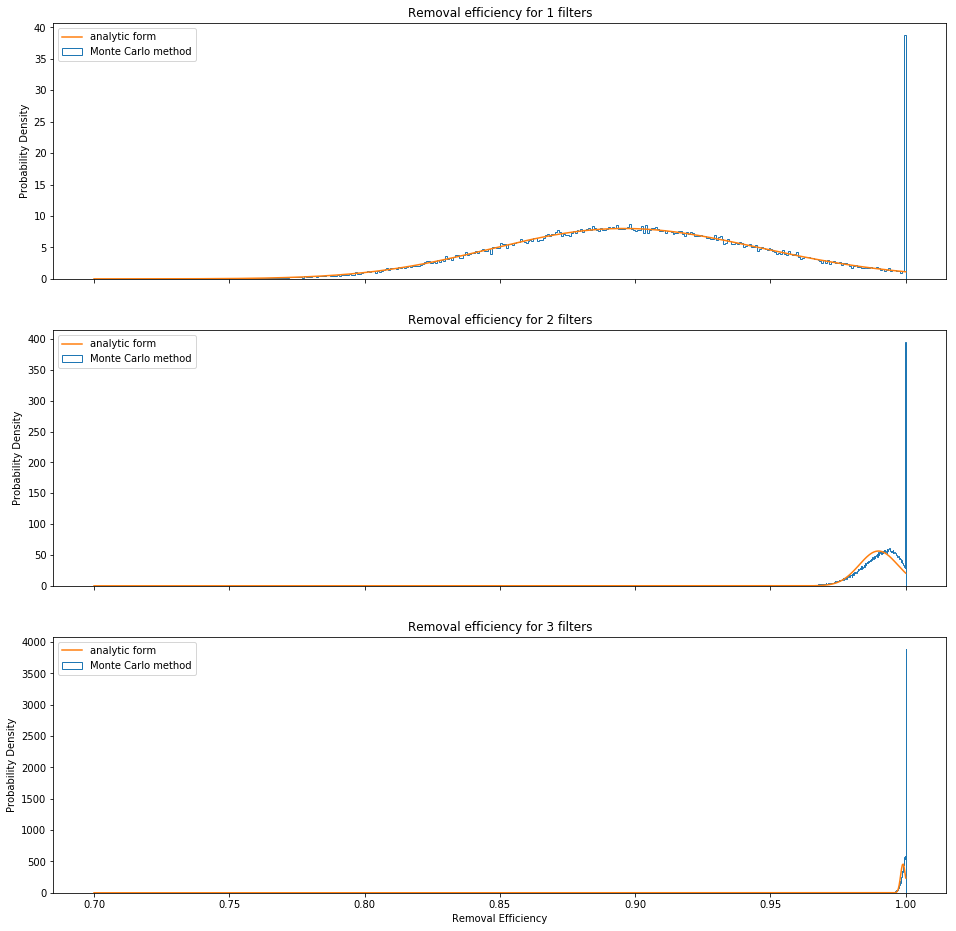

In [6]:
class Filtration:
    def __init__(self):
        self.sample_size = 10**5
        # parameters mu and sigma for lognormal given mean and standard deviation
        self.mu_c = 1.455696
        self.sigma_c = 0.554513
        self.mu_e = -0.1069
        self.sigma_e = 0.05551276
        
    def apply_filters(self, num):
        c = np.random.lognormal(self.mu_c, self.sigma_c)
        if num == 0:
            return c
        else:
            for i in range(num):
                e = min(np.random.lognormal(self.mu_e, self.sigma_e), 1)
                c *= 1-e
            return c

    def get_eff(self, num):
        eff = 1
        for i in range(num):
            e = min(np.random.lognormal(self.mu_e, self.sigma_e), 1)
            eff *= 1-e
        eff = 1 - eff
        return eff
        
    def mc_cost(self, num_filters):
        mean_costs = []
        filter_costs = [n*10**5 for n in range(num_filters+1)]
        for n in range(num_filters+1):
            costs = []
            for run in range(self.sample_size):
                run_c = self.apply_filters(n)
                p_outbreak = np.clip(1/1.95*(run_c-0.05), 0, 1)
                run_cost = n*(10**5) + p_outbreak*(10**6)
                costs.append(run_cost)
            mean_cost = np.mean(costs)
            mean_costs.append(mean_cost)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.plot(mean_costs, label='Expected total cost')
        ax.plot(filter_costs, label='filter costs')
        ax.plot([(m - c) for m,c in zip(mean_costs, filter_costs)], label='Expected outbreak cost')
        ax.legend()
        ax.set_xlabel('Number of filters')
        ax.set_ylabel('Costs in thousands of USD')
        ticks = map(int, ax.get_yticks()*10**(-3))
        ax.set_yticklabels(ticks)
        ax.set_xlim(0, num_filters)
        plt.grid()
        plt.show()
                
    def mc_eff(self, num_filters):
        fig, ax = plt.subplots(num_filters, 1, figsize=(16, 16), sharex=True)
        for n in range(num_filters):
            es = []
            for run in range(self.sample_size):
                run_eff = self.get_eff(n+1)
                es.append(run_eff)
            ax[n].hist(es, bins=400, density=True, histtype='step', label='Monte Carlo method')
            x = np.linspace(0.7, 1, 1000)
            mean_n = 1-0.1**(n+1)
            var_n = (n+1)*1.0/4 * (0.1)**(2*(n+1))
            sigma_en = np.sqrt(np.log(var_n*1.0/mean_n**2 + 1))
            mu_en = np.log(1-0.1**(n+1)) - sigma_en**2*1.0/2 
            ax[n].plot(x, stats.lognorm.pdf(x, s=sigma_en, scale=np.exp(mu_en)), label='analytic form')
            ax[n].set_ylabel('Probability Density')
            ax[n].set_title('Removal efficiency for %i filters' % (n+1))
            ax[n].legend(loc=2)
            #ax[n].grid()
        ax[num_filters-1].set_xlabel('Removal Efficiency')
        plt.show()

    
filt = Filtration()
filt.mc_eff(3)

Note the spikes where the efficiency is 1, indicating that the probability of removal efficiency being equal to $1$ is the integral of the lognormal pdf from $1$ to $\infty$.

#### b. How many filter stages should be employed?

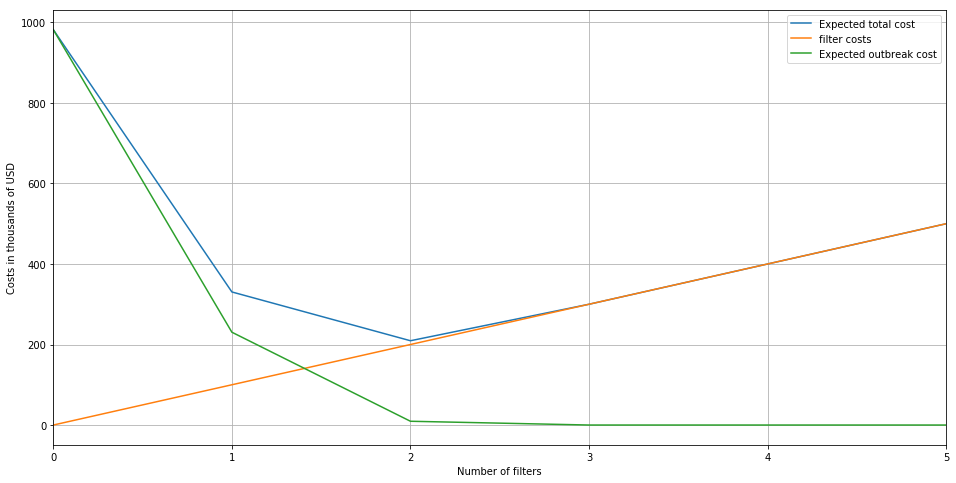

In [7]:
filt.mc_cost(5)

From the above plot, we see that using 2 filter stages will minimize the expected total cost. Therefore, using 2 filters is the preferred alternative.

### 3. Probabilistic Peak Flood Flows

$$Q = \frac{k}{n} A R^{2/3} S^{1/2}$$

$$S = 0.01, \quad A = 500 \text{ ft}^2, \quad R = 30 \text{ ft}, \quad k = 1.49$$

$$F_N(n) = \frac{(n-0.06)}{0.02}, \quad 0.06 \leq n \leq 0.08$$

$$F_Q(q) = P(\frac{k}{N} A R^{2/3} S^{1/2} \leq q) = P(N \geq \frac{k}{q} A R^{2/3} S^{1/2}) = 1 - F_N(\frac{k}{q} A R^{2/3} S^{1/2}) = 1 - \frac{\frac{k}{q} A R^{2/3} S^{1/2}-0.06}{0.02}$$

$$F_Q(q) = 4 - \frac{\frac{k}{q} A R^{2/3} S^{1/2}}{0.02}, \quad  8991.12 \leq q \leq 11988.2$$

$$\boxed{f_Q(q) = \frac{\partial F_Q(q)}{\partial q} = \frac{\frac{k}{q^2} A R^{2/3} S^{1/2}}{0.02} =  \frac{35964.5}{q^2}, \quad  8991.12 \leq q \leq 11988.2,} \quad \text{where }q\text{ is in cfs.}$$